# LAB CAE
## Exercise 1

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset

from torch.utils.data import Dataset
from torch.utils.data import random_split

import CAE
from CAE import load_model, CAE_1_Color

torch.manual_seed(42)

from tqdm import tqdm

In [2]:
# Custom Dataset wrapper for return the original image as label
class AutoencoderDataset(Dataset):
    def __init__(self, original_dataset):
        self.dataset = original_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  # Ignore the label
        return image, image  # Return the image as both input and target


In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.is_available())
# print(torch.version.cuda)
# print(f"Using device: {device}")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = torchvision.datasets.CIFAR10(
    root='', train=True, download=False, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='', train=False, download=False, transform=transform
)

full_dataset = ConcatDataset([train_dataset, test_dataset])

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size  # Ensure all samples are used

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

In [5]:
train_autoencoder_dataset = AutoencoderDataset(train_dataset)
val_autoencoder_dataset = AutoencoderDataset(val_dataset)
test_autoencoder_dataset = AutoencoderDataset(test_dataset)

batch_size = 64

train_loader = DataLoader(
    train_autoencoder_dataset,
    batch_size=batch_size,
    shuffle=True,  # shuffles data for each epoch
    num_workers=0  # number of subprocesses for loading data
)

test_loader = DataLoader(
    test_autoencoder_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [6]:
import matplotlib.pyplot as plt
import numpy as np


# Helper function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

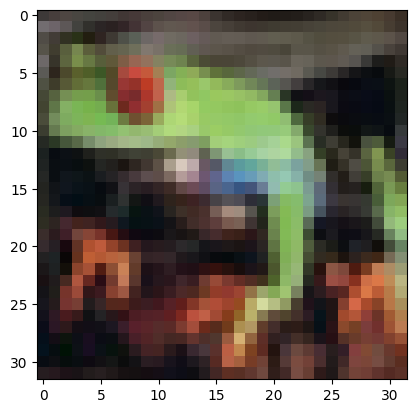

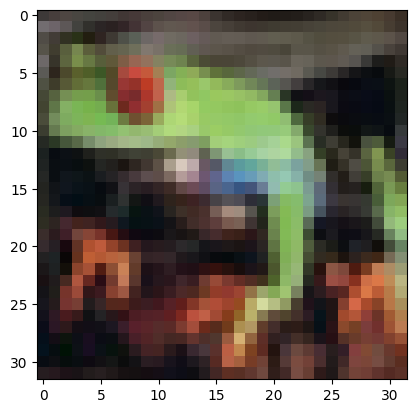

In [7]:
# Get a batch of training data
image, label = train_autoencoder_dataset[0]
# Show a single Image
imshow(image)
imshow(label)


In [8]:
import torch.nn as nn
import torch.optim as optim


# Define a simple CNN model
class SimpleCAE(nn.Module):
    def __init__(self):
        super(SimpleCAE, self).__init__()
        # Define Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 12, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(12, 16, 3, padding=1)
        )
        # Define Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(16, 12, 3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(12, 3, 3, padding=1)
        )

    def forward(self, x):
        # print(f"Received input Data with shape: {x.shape}")
        x = self.encoder(x)
        # print(f"Encoder finished and has Latent Space Representation of shape: {x.shape}")
        x = self.decoder(x)
        # print(f"Decoder finished and output has shape: {x.shape}")
        return x

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)


Model loaded and ready for inference.


C:\Users\Johan\PycharmProjects\ACML_Backprop\CAE.py:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(path))


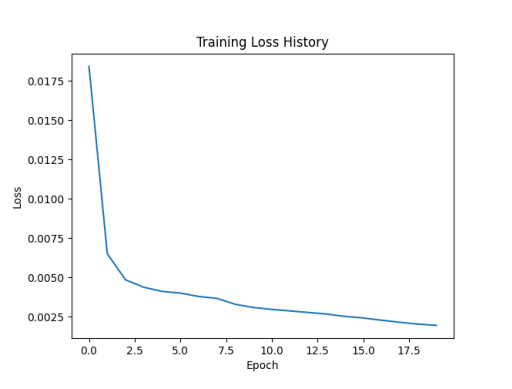

In [9]:
import CAE
from CAE import SimpleCAE

#Load Model that was previously trained with 20 Epochs and Adam Optimizer
model = CAE.load_model("CAE_from_Assignment.pth", SimpleCAE)
from PIL import Image
import matplotlib.pyplot as plt

# Open the image file
loss_history_image = Image.open("loss_history_simple_CAE.png")

# Display the image
plt.imshow(loss_history_image)
plt.axis('off')  # Optional: turn off axis labels
plt.show()

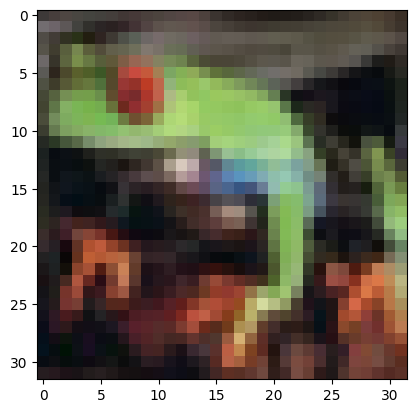

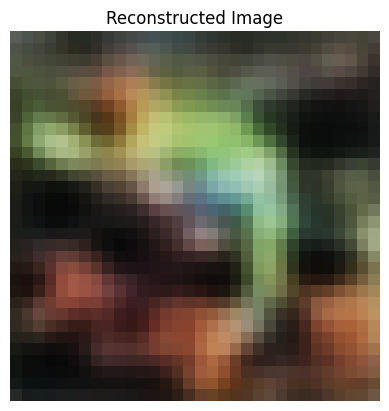

In [10]:
#Example Image

from torchvision.transforms.functional import to_pil_image

image, _ = train_autoencoder_dataset[0]
imshow(image)  # Get an example from the dataset
input_tensor = image.unsqueeze(0)
with torch.no_grad():  # No gradient computation for inference
    reconstructed_tensor = model(input_tensor)
reconstructed_tensor = reconstructed_tensor.squeeze(0).cpu()
reconstructed_tensor = torch.clamp(reconstructed_tensor, 0, 1)
reconstructed_image = to_pil_image(reconstructed_tensor)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()


In [11]:
def compute_test_error(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # No gradient calculation during inference
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs, labels

            # Forward pass: get the model's output (reconstructed image)
            outputs = model(inputs)

            # Compute the loss (MSE between original and reconstructed images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)  # Multiply by batch size to accumulate loss
            total_samples += inputs.size(0)  # Count total number of samples

    # Average test loss
    avg_loss = total_loss / total_samples
    return avg_loss


criterion = nn.MSELoss()
test_error = compute_test_error(model, test_loader, criterion)
print(f'Test Error (MSE Loss): {test_error:.4f}')


100%|██████████| 94/94 [00:00<00:00, 145.41it/s]

Test Error (MSE Loss): 0.0043


## Exercise 2

In [12]:
print(model.encode(image).shape)

torch.Size([16, 8, 8])


This means the Latent space is of size 1024.

Model loaded and ready for inference.


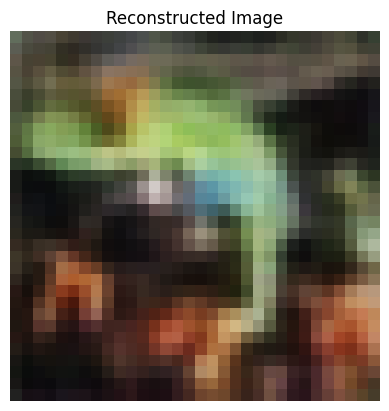

100%|██████████| 94/94 [00:00<00:00, 175.98it/s]

Test Error(MSE) for CAE_1: 0.0018


In [13]:
from CAE import CAE_1

#Removed pooling and up sampling in favour of trainable dimensionality increase and decrease
model = CAE.load_model("CAE1.pth", CAE_1)
with torch.no_grad():  # No gradient computation for inference
    reconstructed_tensor = model(input_tensor)
reconstructed_tensor = reconstructed_tensor.squeeze(0).cpu()
reconstructed_tensor = torch.clamp(reconstructed_tensor, 0, 1)
reconstructed_image = to_pil_image(reconstructed_tensor)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()
print(f"Test Error(MSE) for CAE_1: {CAE.compute_test_error(model, test_loader, criterion):.4f}")

Model loaded and ready for inference.


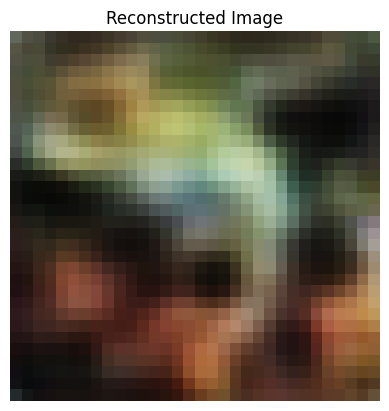

100%|██████████| 94/94 [00:00<00:00, 148.35it/s]

Test Error(MSE) for CAE_2: 0.0051


In [14]:
from CAE import CAE_2

#Reduced Latent space to showcase its impact
model = CAE.load_model("CAE2.pth", CAE_2)
with torch.no_grad():  # No gradient computation for inference
    reconstructed_tensor = model(input_tensor)
reconstructed_tensor = reconstructed_tensor.squeeze(0).cpu()
reconstructed_tensor = torch.clamp(reconstructed_tensor, 0, 1)
reconstructed_image = to_pil_image(reconstructed_tensor)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()
print(f"Test Error(MSE) for CAE_2: {CAE.compute_test_error(model, test_loader, criterion):.4f}")

## Exercise 3

Model loaded and ready for inference.


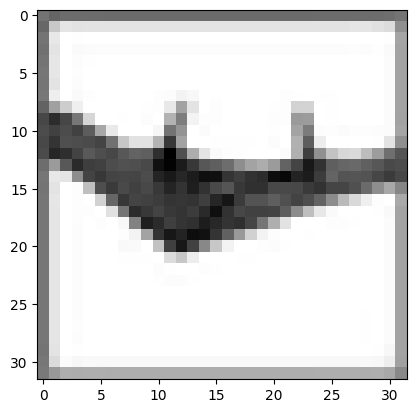

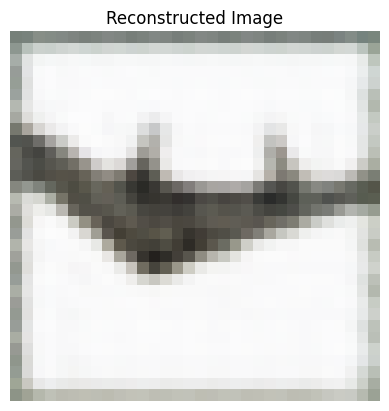

100%|██████████| 47/47 [00:06<00:00,  7.73it/s]

Test Error(MSE) for CAE_2: 0.0073


In [26]:
from CAE import CAE_1_Color
train_color_loader,test_color_loader=CAE.get_DataLoaders(CAE.ColorEncoderDataset)
model = CAE.load_model("CAE1_color.pth", CAE_1_Color)

image, _ = train_autoencoder_dataset[3]
image=transforms.Grayscale(num_output_channels=1)(image)
plt.imshow(image[0],cmap='gray')
plt.show()# Get an example from the dataset
input_tensor = image.unsqueeze(0)
with torch.no_grad():  # No gradient computation for inference
    reconstructed_tensor = model(input_tensor)
reconstructed_tensor = reconstructed_tensor.squeeze(0).cpu()
reconstructed_tensor = torch.clamp(reconstructed_tensor, 0, 1)
reconstructed_image = to_pil_image(reconstructed_tensor)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()
print(f"Test Error(MSE) for CAE_2: {CAE.compute_test_error(model, test_color_loader, criterion):.4f}")